In [1]:
import pandas as pd
import numpy as np
import time
import math
from scipy import stats
from tabulate import tabulate
from pprint import pprint
import matplotlib.pyplot as plt


__Preprocessing the data__

In [2]:
def data_loading():
    """
    Load the data from the excel file and preprocess it.
    
    Returns:
    - data (pd.DataFrame): Preprocessed data.
    """
    # Load the data from the excel file
    data = pd.read_excel('gasstationdata33.xlsx')
    
    # Drop the 'Unnamed: 0' column
    data = data.drop(columns=['Unnamed: 0'])

    data = pd.DataFrame(data)
    
    arrivals_datetime = [arrival.to_pydatetime() for arrival in data["Arrival Time"]]

    data["Interarrival Times"] = data["Arrival Time"].diff().dt.total_seconds().fillna(0)

    # Calculate the hour of the day
    data['Arrival Time (H)'] = data['Arrival Time'].dt.hour

    # replace nan values in Parking preference with None
    data['Parking preference'] = data['Parking Preference'].fillna('None')

    data["Shope-time-no-zero"] = data[data["Shop time"] > 0 ]["Shop time"]
    
    # Convert the attributes to minutes
    attributes = ['Service time Fuel', 'Shop time', 'Service time payment', 'Interarrival Times', 'Shope-time-no-zero']
    
    return data

data = data_loading()
data.head()

,Customer,Arrival Time,Parking Preference,Service time Fuel,Shop time,Service time payment,Interarrival Times,Arrival Time (H),Parking preference,Shope-time-no-zero
0,0,2024-02-01 06:00:06.644,NaN,181,0,46,0.000,6,None,NaN
1,1,2024-02-01 06:03:05.847,Left,158,29,38,179.203,6,Left,29.0
2,2,2024-02-01 06:05:45.348,NaN,357,0,39,159.501,6,None,NaN
3,3,2024-02-01 06:07:31.426,Right,802,0,37,106.078,6,Right,NaN
4,4,2024-02-01 06:15:28.037,Right,359,0,50,476.611,6,Right,NaN


In [3]:
# calculate the test statistics such as mean, std , skewness, kurtosis, median, mode, range, min, max, 25th percentile, 50th percentile, 75th percentile of the payment service time column
def calculate_statistics(data):
    """
    Calculate the test statistics such as mean, std , skewness, kurtosis, median, mode, range, min, max, 25th percentile, 50th percentile, 75th percentile of the payment service time.
    
    Args:
    - data (pd.DataFrame): Preprocessed data.
    
    Returns:
    - statistics (dict): Test statistics.
    """
    # Calculate the test statistics
    statistics = {
        'Mean': data['Service time payment'].mean(),
        'Std': data['Service time payment'].std(),
        'Skewness': data['Service time payment'].skew(),
        'Kurtosis': data['Service time payment'].kurtosis(),
        'Median': data['Service time payment'].median(),
        'Mode': data['Service time payment'].mode().values[0],
        'Range': data['Service time payment'].max() - data['Service time payment'].min(),
        'Min': data['Service time payment'].min(),
        'Max': data['Service time payment'].max(),
        '25th Percentile': data['Service time payment'].quantile(0.25),
        '50th Percentile': data['Service time payment'].quantile(0.50),
        '75th Percentile': data['Service time payment'].quantile(0.75)
    }
    
    return statistics

statistics = calculate_statistics(data)
print(tabulate(statistics.items(), headers=['Statistics', 'Value'], tablefmt='fancy_grid'))



╒═════════════════╤═══════════╕
│ Statistics      │     Value │
╞═════════════════╪═══════════╡
│ Mean            │ 45.6603   │
├─────────────────┼───────────┤
│ Std             │  5.62825  │
├─────────────────┼───────────┤
│ Skewness        │ -0.122258 │
├─────────────────┼───────────┤
│ Kurtosis        │ -1.08465  │
├─────────────────┼───────────┤
│ Median          │ 46        │
├─────────────────┼───────────┤
│ Mode            │ 51        │
├─────────────────┼───────────┤
│ Range           │ 20        │
├─────────────────┼───────────┤
│ Min             │ 35        │
├─────────────────┼───────────┤
│ Max             │ 55        │
├─────────────────┼───────────┤
│ 25th Percentile │ 41        │
├─────────────────┼───────────┤
│ 50th Percentile │ 46        │
├─────────────────┼───────────┤
│ 75th Percentile │ 51        │
╘═════════════════╧═══════════╛


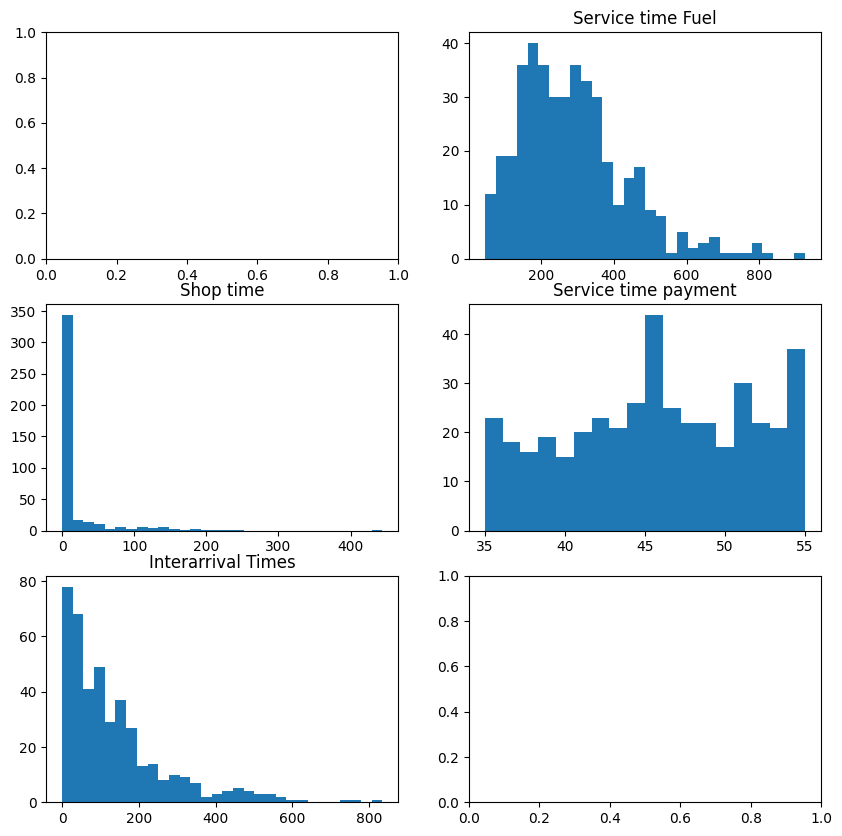

In [4]:
fig, axs = plt.subplots(3, 2, figsize=(10, 10))

# axs[0,0].hist(data["Parking Preference"], bins=30)
# axs[0,0].set_title("Parking Preference")

axs[0,1].hist(data["Service time Fuel"], bins=30)
axs[0,1].set_title("Service time Fuel")

axs[1,0].hist(data["Shop time"], bins=30)
axs[1,0].set_title("Shop time")

axs[1,1].hist(data["Service time payment"], bins=18)
axs[1,1].set_title("Service time payment")

axs[2,0].hist(data["Interarrival Times"], bins=30)
axs[2,0].set_title("Interarrival Times")

# axs[0,0].hist(interarrival_times, bins=30)
# axs[1].hist(fuel_time, bins=20)
# axs[2].hist(shop_time, bins= math.floor(np.sqrt(len(shop_time))))
# axs[2].set_xlim(0, 200)

# show the plot
plt.show()

__Testing underlying distributions__

In [5]:
# conver the shop time into a binary variable
shop_time = data["Shop time"]
shop_time = shop_time.apply(lambda x: 1 if x > 0 else 0)

count_1 = shop_time[shop_time == 1].count()
count_0 = shop_time[shop_time == 0].count()

percentage_1 = count_1 / (count_1 + count_0)
percentage_0 = count_0 / (count_1 + count_0)

# print (percentage_0, percentage_1)



def calculate_shop_probabilities(data):
    """
    Calculate the probabilities of having a shop time and the conditional probabilities of having a shop time or not.
    
    Parameters:
    - data (pd.DataFrame): DataFrame containing shop times.
    
    Returns:
    - probabilities (dict): Dictionary containing calculated probabilities.
    """
    shop_time = data["Shop time"]
    total_len = len(shop_time)
    has_shop_time = shop_time[shop_time > 0]
    
    probabilities = {
        "probability_of_shop_time": len(has_shop_time) / total_len,
        "probability_of_no_shop_time": 1 - len(has_shop_time) / total_len,
        "count_total": total_len,
        "count_shop_time": len(has_shop_time),
    }
    
    
    return probabilities

def test_binomial_distribution(probabilities, alternative="two-sided", p_value = 0.05):
    """
    Test for binomial distribution of shop time.
    
    Parameters:
    - probabilities (dict): Dictionary containing calculated probabilities.
    - total_len (int): Total number of shop times.
    
    Returns:
    - test_results (dict): Dictionary containing test results.
    """
    test_results = {
        "test_for_shop_time_binom": stats.binomtest(
            probabilities["count_shop_time"],
            probabilities["count_total"],
            p=probabilities["probability_of_shop_time"],
            alternative=alternative
        ),
        # "test_for_sh"
    }
    
    formatted_results = [{"Test": key, "Result": value, "Significance":value.pvalue>=p_value} for key, value in test_results.items()]
    
    # Use tabulate to format the output
    print(tabulate(formatted_results, headers="keys", tablefmt="pretty"))
    return test_results


# Calculate the probabilities
shop_probabilities = calculate_shop_probabilities(data)
pprint(shop_probabilities)
# test_results = test_binomial_distribution(shop_probabilities)

{'count_shop_time': 94,
 'count_total': 421,
 'probability_of_no_shop_time': 0.7767220902612827,
 'probability_of_shop_time': 0.22327790973871733}


In [6]:
def calculate_preference_probabilities(data):
    """
    Calculate the probabilities of having a parking preference and the conditional probabilities of preferring right or left.
    
    Parameters:
    - data (pd.DataFrame): DataFrame containing parking preferences.
    
    Returns:
    - probabilities (dict): Dictionary containing calculated probabilities.
    """
    preferences = data["Parking Preference"]
    total_len = len(preferences)
    has_preference = preferences[(preferences == "Right") | (preferences == "Left")]
    
    probabilities = {
        "probability_of_preference": len(has_preference) / total_len,
        "probability_of_no_preference": 1 - len(has_preference) / total_len,
        "probability_of_right": has_preference[has_preference == "Right"].count() / len(has_preference),
        "probability_of_left": has_preference[has_preference == "Left"].count() / len(has_preference),
        "count_total": total_len,
        "count_preference": len(has_preference),
        "count_right": has_preference[has_preference == "Right"].count(),
        "count_left": has_preference[has_preference == "Left"].count()
        
    }
    
    return probabilities

def test_binomial_distribution(probabilities, alternative="two-sided", p_value = 0.05):
    """
    Test for binomial distribution of preference and left/right parking preferences.
    
    Parameters:
    - probabilities (dict): Dictionary containing calculated probabilities.
    - total_len (int): Total number of parking preferences.
    
    Returns:
    - test_results (dict): Dictionary containing test results.
    """
    test_results = {
        "test_for_preference": stats.binomtest(
            probabilities["count_preference"],
            probabilities["count_total"],
            p=probabilities["probability_of_preference"],
            alternative=alternative
        ),
        "test_for_left": stats.binomtest(
            probabilities["count_left"],
            (probabilities["count_preference"]),
            p=probabilities["probability_of_left"],
            alternative=alternative
            
        ),
        "test_for_right": stats.binomtest(
            probabilities["count_right"],
            (probabilities["count_preference"]),
            p=probabilities["probability_of_right"],
            alternative=alternative
    
        ),
    }    
    
    formatted_results = [{"Test": key, "Result": value, "Significance":value.pvalue>=p_value} for key, value in test_results.items()]
    
    # Use tabulate to format the output
    print(tabulate(formatted_results, headers="keys", tablefmt="pretty"))
    return test_results


# Calculate the probabilities
preferences_probabilities = calculate_preference_probabilities(data)
test_results = test_binomial_distribution(preferences_probabilities)



+---------------------+------------------------------------------------------------------------------------------------+--------------+
|        Test         |                                             Result                                             | Significance |
+---------------------+------------------------------------------------------------------------------------------------+--------------+
| test_for_preference | BinomTestResult(k=72, n=421, alternative='two-sided', statistic=0.171021377672209, pvalue=1.0) |     True     |
|    test_for_left    | BinomTestResult(k=40, n=72, alternative='two-sided', statistic=0.5555555555555556, pvalue=1.0) |     True     |
|   test_for_right    | BinomTestResult(k=32, n=72, alternative='two-sided', statistic=0.4444444444444444, pvalue=1.0) |     True     |
+---------------------+------------------------------------------------------------------------------------------------+--------------+


#TODO
- []

In [7]:


def analyze_distributions(data, list_of_attributes):
    """
    Analyze the distributions of the given attributes in the data.
    :param data: 
    :param list_of_attributes: 
    :return: 
    """
    results = []

    output_parameters = {}

    for attribute in list_of_attributes:
        output_parameters[attribute] = {}
        # # Remove all zeros
        # data = data[data[attribute] != 0]
        # # Remove all NaN
        # data = data.dropna(subset=[attribute])

        # Exponential distribution
        m1 = np.mean(data[attribute])
        fit_exponential_dist = stats.expon(scale=1 / m1)
        test = stats.kstest(data[attribute], fit_exponential_dist.cdf)
        p_value = test[1]
        fit_status = "Good fit" if p_value > 0.05 else "Bad fit"
        results.append([attribute, "Exponential Distribution", fit_status, p_value])
        output_parameters[attribute]["Exponential Distribution"] = ({
            "estimated_lambda": 1 / m1
        })

        

        # Gamma distribution
        m2 = np.mean([x**2 for x in data[attribute]])
        est_beta = m1 / (m2 - m1**2)
        est_alpha = m1 * est_beta
        fit_gamma_dist = stats.gamma(a=est_alpha, scale=1 / est_beta)
        test = stats.kstest(data[attribute], fit_gamma_dist.cdf)
        p_value = test[1]
        fit_status = "Good fit" if p_value > 0.05 else "Bad fit"
        results.append([attribute, "Gamma Distribution", fit_status, p_value])
        output_parameters[attribute]["Gamma Distribution"] =({
            "estimated_alpha": est_alpha,
            "estimated_beta": est_beta
        })

        # Poisson distribution
        fi_poisson_dist = stats.poisson(mu=m1)
        test = stats.kstest(data[attribute], fi_poisson_dist.cdf)
        p_value = test[1]
        fit_status = "Good fit" if p_value > 0.05 else "Bad fit"
        results.append([attribute, "Poisson Distribution", fit_status, p_value])
        
        output_parameters[attribute]["Poisson Distribution"]=({
            "estimated_lambda": m1
        })

        # Normal distribution
        estimated_std = m2 - m1**2
        fit_normal_dist = stats.norm(loc=m1, scale=estimated_std)
        test = stats.kstest(data[attribute], fit_normal_dist.cdf)
        p_value = test[1]
        fit_status = "Good fit" if p_value > 0.05 else "Bad fit"
        results.append([attribute, "Normal Distribution", fit_status, p_value])
        
        output_parameters[attribute]["Normal Distribution"]=({
            "estimated_mean": m1,
            "estimated_std": estimated_std
        })

    # Convert the results list to a DataFrame for easier manipulation
    results_df = pd.DataFrame(results, columns=["Attribute", "Distribution", "Fit Status", "P-value"])

    return results_df, output_parameters

list_of_attributes = ["Service time Fuel", "Shop time", "Service time payment", "Interarrival Times"]
fit_status, parameters = analyze_distributions(data, list_of_attributes)
print(tabulate(fit_status, headers='keys', tablefmt='pretty'))

+----+----------------------+--------------------------+------------+-------------------------+
|    |      Attribute       |       Distribution       | Fit Status |         P-value         |
+----+----------------------+--------------------------+------------+-------------------------+
| 0  |  Service time Fuel   | Exponential Distribution |  Bad fit   |           0.0           |
| 1  |  Service time Fuel   |    Gamma Distribution    |  Good fit  |   0.8995139987322393    |
| 2  |  Service time Fuel   |   Poisson Distribution   |  Bad fit   |  3.020669518714976e-77  |
| 3  |  Service time Fuel   |   Normal Distribution    |  Bad fit   |  4.626152465926528e-96  |
| 4  |      Shop time       | Exponential Distribution |  Bad fit   | 1.5371844167214613e-268 |
| 5  |      Shop time       |    Gamma Distribution    |  Bad fit   | 1.5371844167214613e-268 |
| 6  |      Shop time       |   Poisson Distribution   |  Bad fit   | 1.0217834682876692e-284 |
| 7  |      Shop time       |   Normal D

In [8]:
def selecting_distribution(fit_status, parameters):
    """
    Select the best distribution for each attribute.
    
    Parameters:
    - fit_status (pd.DataFrame): DataFrame containing the results of the distribution analysis.
    - parameters (dict): Dictionary containing the parameters of the distributions.
    
    Returns:
    - selected_distributions (dict): Dictionary containing the selected distributions for each attribute.
    """
    selected_distributions = {}
    
    # Filter the parameters DataFrame to only include good fits
    good_fits = fit_status[fit_status["Fit Status"] == "Good fit"]
    
    # Create a dictionary to store the distribution type and p-value for each attribute
    dist_type = {}
    
    # Iterate over the good fits
    for index, row in good_fits.iterrows():
        # If the attribute is not in the dictionary, add it
        if row["Attribute"] not in dist_type:
            dist_type[row["Attribute"]] = (row["Distribution"], row["P-value"])
        # If the p-value is higher than the current p-value, update the distribution type
        else:
            if row["P-value"] > dist_type[row["Attribute"]][1]:
                dist_type[row["Attribute"]] = (row["Distribution"], row["P-value"])
    
    # Create a dictionary to store the parameters of the selected distributions
    results = {}
    
    # Iterate over the distribution types
    for attribute, value in dist_type.items():
        # Add the distribution type and parameters to the results dictionary
        results[attribute] = (value[0], parameters[attribute][value[0]])
    
    # Return the selected distributions
    return results

# Select the best distribution for each attribute
selected_distributions = selecting_distribution(fit_status, parameters)

pprint(selected_distributions)

{'Interarrival Times': ('Gamma Distribution',
                        {'estimated_alpha': 0.9812872311753369,
                         'estimated_beta': 0.00718045431326548}),
 'Service time Fuel': ('Gamma Distribution',
                       {'estimated_alpha': 3.740741878984356,
                        'estimated_beta': 0.012899532551254148})}


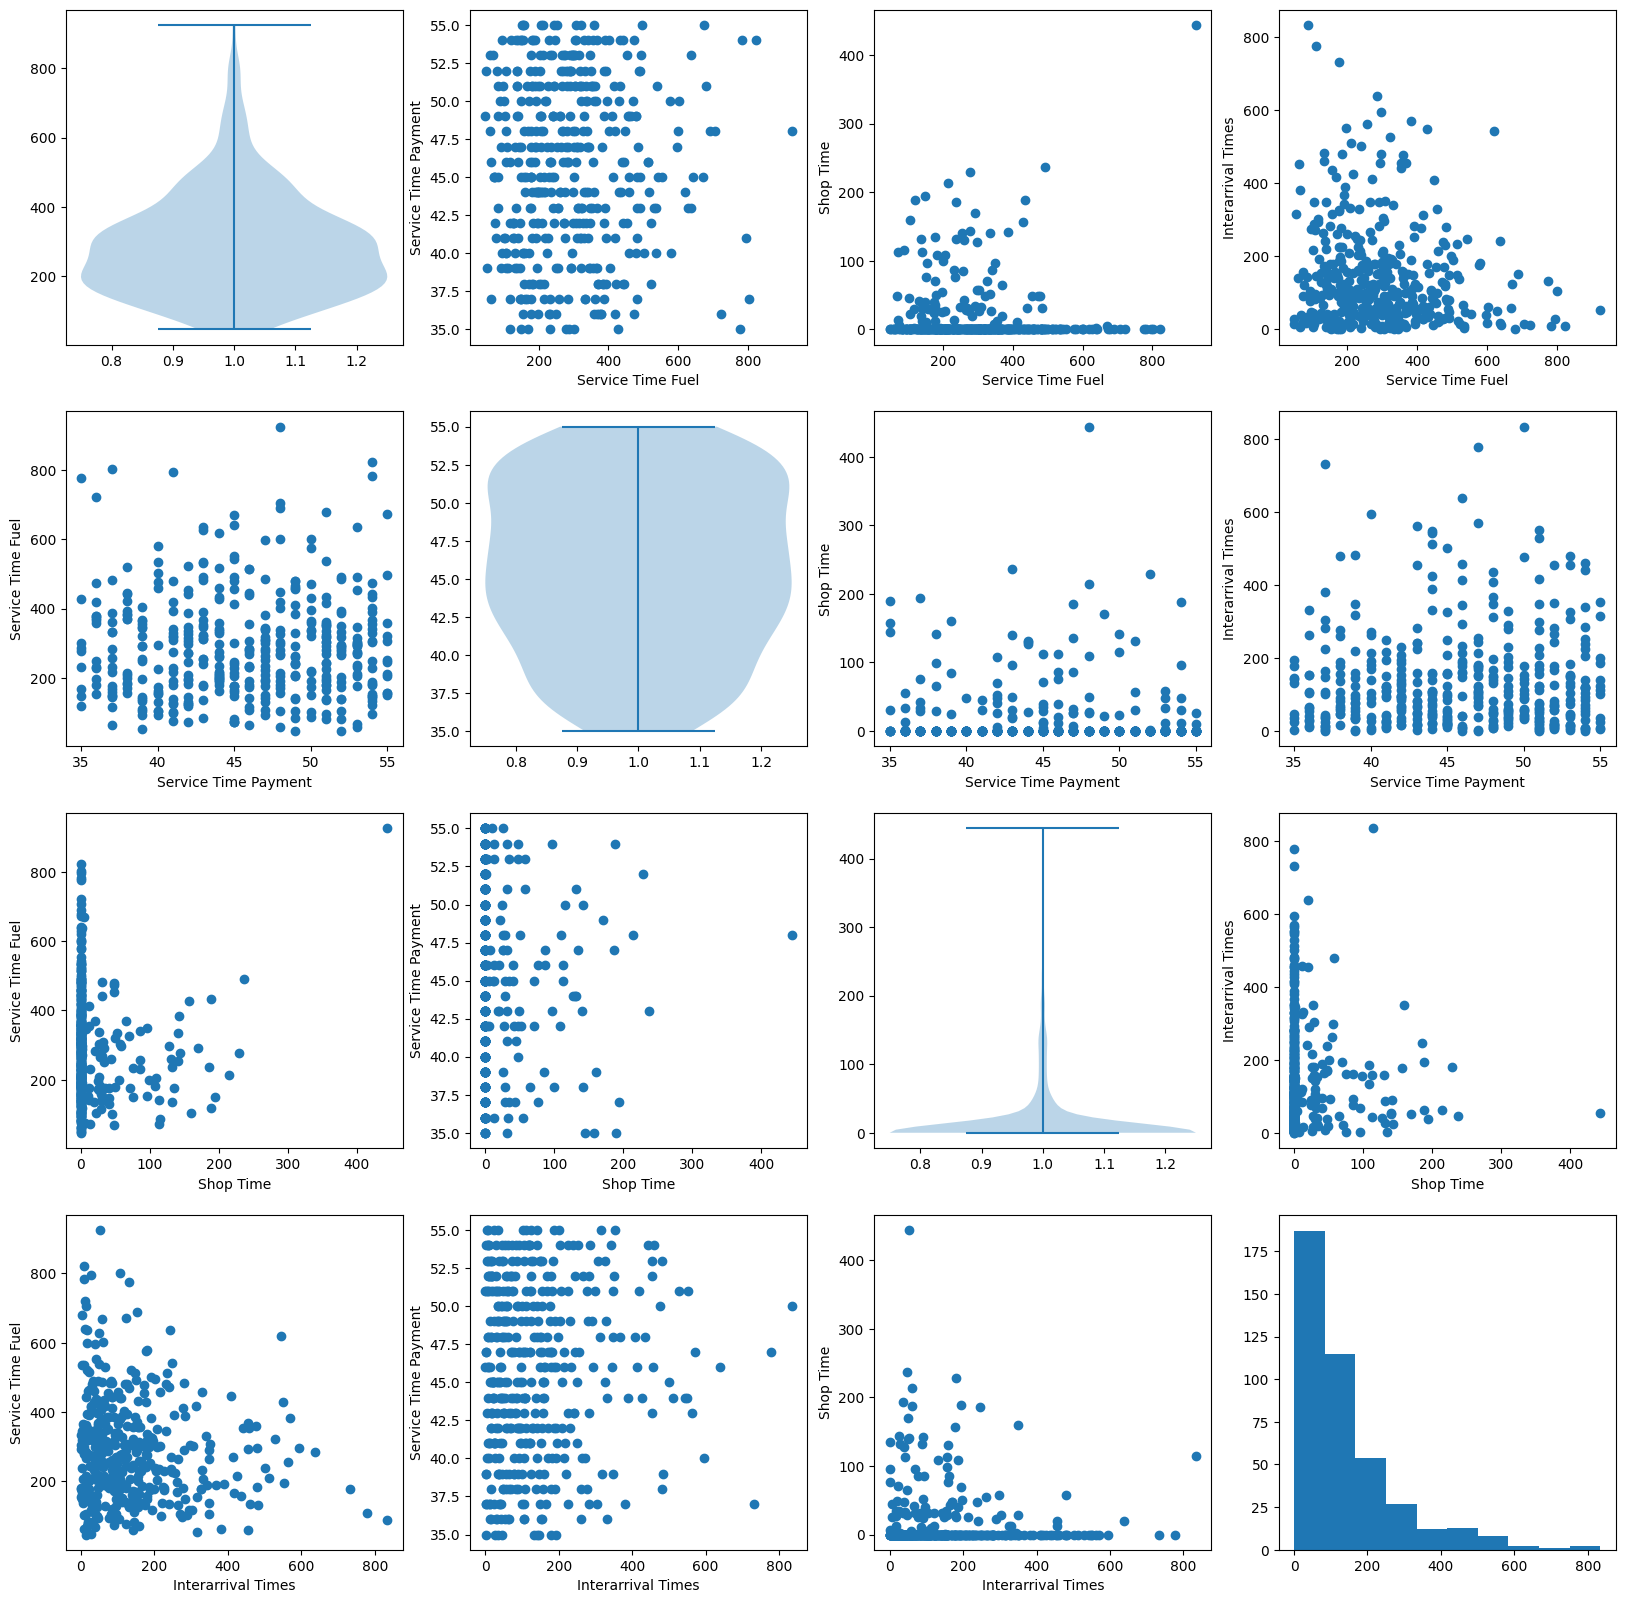

In [9]:
# SPLOM
fig, axs = plt.subplots(4, 4, figsize=(20, 20))
axs[0,0].violinplot(data["Service time Fuel"])

axs[0,1].scatter(data["Service time Fuel"], data["Service time payment"])
axs[0,1].set_xlabel("Service Time Fuel")
axs[0,1].set_ylabel("Service Time Payment")

axs[0,2].scatter(data["Service time Fuel"], data["Shop time"])
axs[0,2].set_xlabel("Service Time Fuel")
axs[0,2].set_ylabel("Shop Time")

axs[0,3].scatter(data["Service time Fuel"], data["Interarrival Times"])
axs[0,3].set_xlabel("Service Time Fuel")
axs[0,3].set_ylabel("Interarrival Times")



axs[1,0].scatter(data["Service time payment"], data["Service time Fuel"])
axs[1,0].set_xlabel("Service Time Payment")
axs[1,0].set_ylabel("Service Time Fuel")

axs[1,1].violinplot(data["Service time payment"])

axs[1,2].scatter(data["Service time payment"], data["Shop time"])
axs[1,2].set_xlabel("Service Time Payment")
axs[1,2].set_ylabel("Shop Time")


axs[1,3].scatter(data["Service time payment"], data["Interarrival Times"])
axs[1,3].set_xlabel("Service Time Payment")
axs[1,3].set_ylabel("Interarrival Times")

axs[2,0].scatter(data["Shop time"], data["Service time Fuel"])
axs[2,0].set_xlabel("Shop Time")
axs[2,0].set_ylabel("Service Time Fuel")

axs[2,1].scatter(data["Shop time"], data["Service time payment"])
axs[2,1].set_xlabel("Shop Time")
axs[2,1].set_ylabel("Service Time Payment")

axs[2,2].violinplot( data["Shop time"])

axs[2,3].scatter(data["Shop time"], data["Interarrival Times"])
axs[2,3].set_xlabel("Shop Time")
axs[2,3].set_ylabel("Interarrival Times")



axs[3,0].scatter(data["Interarrival Times"], data["Service time Fuel"])
axs[3,0].set_xlabel("Interarrival Times")
axs[3,0].set_ylabel("Service Time Fuel")

axs[3,1].scatter(data["Interarrival Times"], data["Service time payment"])
axs[3,1].set_xlabel("Interarrival Times")
axs[3,1].set_ylabel("Service Time Payment")



axs[3,2].scatter(data["Interarrival Times"], data["Shop time"])
axs[3,2].set_xlabel("Interarrival Times")
axs[3,2].set_ylabel("Shop Time")

axs[3,3].hist( data["Interarrival Times"]);

In [10]:
import plotly.express as px

def left_right_encoder(x):
    if x == "Left":
        return 1
    elif x == "Right":
        return 2
    else:
        return 0


data["Parking Preference (bin)"] = data["Parking Preference"].apply(lambda x: left_right_encoder(x))
px.parallel_coordinates(
    data_frame=data,
    dimensions=[
        "Parking Preference (bin)",
        "Interarrival Times",
        "Shop time",
        "Service time Fuel",
        "Service time payment",
        # "Parking Preference"
        
    ],
    color="Service time payment"
    # color="Parking Preference (bin)"
)